In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import os
import random
from scipy import ndimage
from skimage.io import*
from skimage.transform import resize

In [3]:
img_files = []
for root, dirs, files in os.walk('/kaggle/input/spines/spine_data/Dataset Intensity'):
    for file in files:
        if file.endswith('.png'):
            img_files.append(os.path.join(root, file))

label_files = []
for root, dirs, files in os.walk('/kaggle/input/spines/spine_data/Dataset Binary'):
    for file in files:
        if file.endswith('.png'):
            label_files.append(os.path.join(root, file))

In [4]:
images = []
labels = []
#resize images and labels to 256x256
for i in range(len(img_files)):
    img = imread(img_files[i])
    img = resize(img, (256, 256))
    images.append(img)

    label = imread(label_files[i])
    label = resize(label, (256, 256))
    labels.append(label)

images = np.array(images)
labels = np.array(labels)

print(images.shape)
print(labels.shape)

(456, 256, 256)
(456, 256, 256)


In [5]:
def sample_points_from_mask(mask, num_points=100):
    foreground_indices = np.argwhere(mask == 1)
    
    if len(foreground_indices) > num_points:
        foreground_points = foreground_indices[np.random.choice(len(foreground_indices), num_points, replace=False)]
    else:
        foreground_points = foreground_indices
    
    return foreground_points

In [6]:
def handle_grayscale_image(image):
    np_image = np.array(image)
    if np_image.ndim == 2:
        tiled_image = np.tile(np.expand_dims(np_image, -1), 3)
        return Image.fromarray((tiled_image*255).astype(np.uint8))
    else:
        return Image.fromarray(np_image)

In [7]:
from datasets import Dataset
from PIL import Image

dataset_dict = {
    'image':[handle_grayscale_image(image) for image in images],
    'label': [Image.fromarray((labels[i]).astype(np.uint8)) for i in range(labels.shape[0])]
}


In [8]:
# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)
print(dataset)

Dataset({
    features: ['image', 'label'],
    num_rows: 456
})


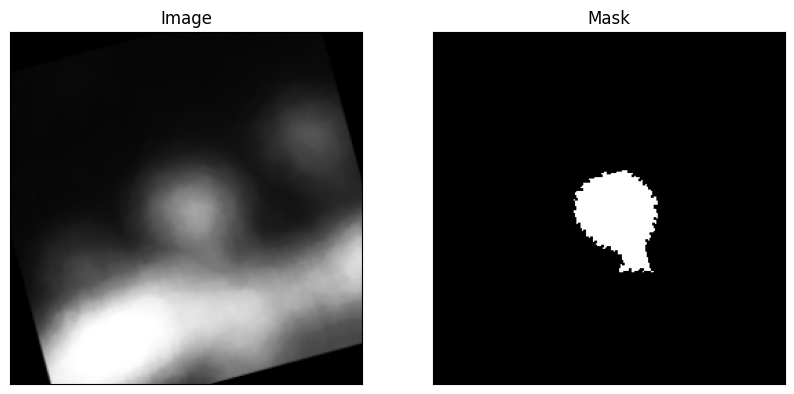

In [9]:
img_num = random.randint(0, img.shape[0]-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

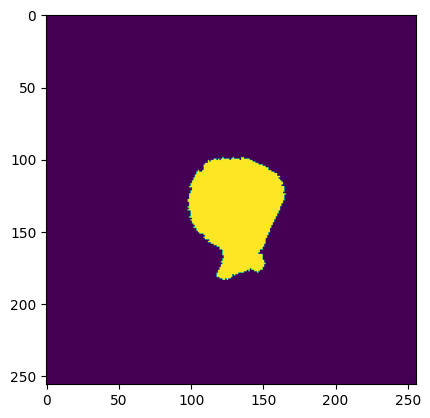

In [10]:
plt.imshow(labels[50])

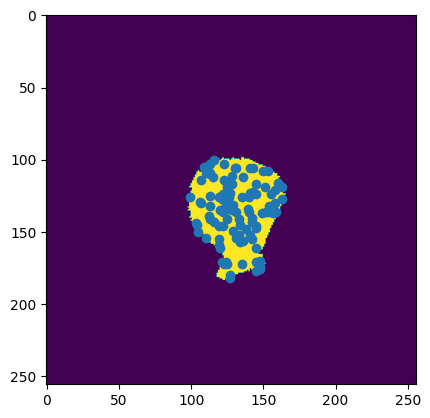

In [11]:
points = sample_points_from_mask(labels[50])
plt.imshow(labels[50])
plt.scatter(points[:,1],points[:,0])

In [12]:
#create pytorch dataset
from torch.utils.data import Dataset
class SpineDataset(Dataset):
    def __init__(self,dataset,processor):
        self.dataset=dataset
        self.processor=processor
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item["image"]
        ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
        prompt = sample_points_from_mask(ground_truth_mask,num_points=50)

    # prepare image and prompt for the model
        inputs = self.processor(image, input_points=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
        inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
        inputs["ground_truth_mask"] = ground_truth_mask
        return inputs

In [13]:
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [14]:
train_dataset = SpineDataset(dataset=dataset, processor=processor)

In [15]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_points torch.Size([1, 50, 2])
ground_truth_mask (256, 256)


In [16]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)

In [17]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_points torch.Size([2, 1, 50, 2])
ground_truth_mask torch.Size([2, 256, 256])


In [18]:
# Load the model
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

In [19]:
! pip install monai -q

In [21]:
from torch.optim import Adam
import monai
# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=2e-5, weight_decay=0) #very low learning rate for fine-tuning
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [22]:
from tqdm.notebook import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

#Training loop
num_epochs = 10
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_points=batch["input_points"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

  0%|          | 0/228 [00:00<?, ?it/s]

EPOCH: 0
Mean loss: 0.2655978262293757


  0%|          | 0/228 [00:00<?, ?it/s]

EPOCH: 1
Mean loss: 0.19375540374925262


  0%|          | 0/228 [00:00<?, ?it/s]

EPOCH: 2
Mean loss: 0.16696374467982536


  0%|          | 0/228 [00:00<?, ?it/s]

EPOCH: 3
Mean loss: 0.1539911032703362


  0%|          | 0/228 [00:00<?, ?it/s]

EPOCH: 4
Mean loss: 0.14515202760434986


  0%|          | 0/228 [00:00<?, ?it/s]

EPOCH: 5
Mean loss: 0.1397881094497024


  0%|          | 0/228 [00:00<?, ?it/s]

EPOCH: 6
Mean loss: 0.12945313375900713


  0%|          | 0/228 [00:00<?, ?it/s]

EPOCH: 7
Mean loss: 0.12512493238114475


  0%|          | 0/228 [00:00<?, ?it/s]

EPOCH: 8
Mean loss: 0.11833782503871541


  0%|          | 0/228 [00:00<?, ?it/s]

EPOCH: 9
Mean loss: 0.11415888016161166


In [23]:
torch.save(model.state_dict(), "spine_model_checkpoint.pth")

In [ ]:
#Inference

In [24]:
from transformers import SamModel, SamConfig, SamProcessor
import torch

In [25]:
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
spine_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
spine_model.load_state_dict(torch.load("/kaggle/working/spine_model_checkpoint.pth"))

<All keys matched successfully>

In [26]:
device = "cuda" if torch.cuda.is_available() else "cpu"
spine_model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

In [38]:
idx = random.randint(0, images.shape[0]-1)

# load image
test_image = dataset[idx]["image"]

# get box prompt based on ground truth segmentation map
gt = np.array(dataset[idx]["label"])
points = sample_points_from_mask(gt,10)

In [39]:
points.shape

(10, 2)

In [40]:
points 

array([[165, 135],
       [222, 129],
       [124, 115],
       [152, 127],
       [202, 139],
       [138, 149],
       [124, 129],
       [114, 137],
       [131, 124],
       [220, 147]])

In [41]:
inputs = processor(test_image, input_points=[[points]], return_tensors="pt")

In [42]:
inputs = {k: v.to(device) for k, v in inputs.items()}

In [43]:
spine_model.eval();

In [44]:
with torch.no_grad():
    outputs = spine_model(**inputs, multimask_output=False)
# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

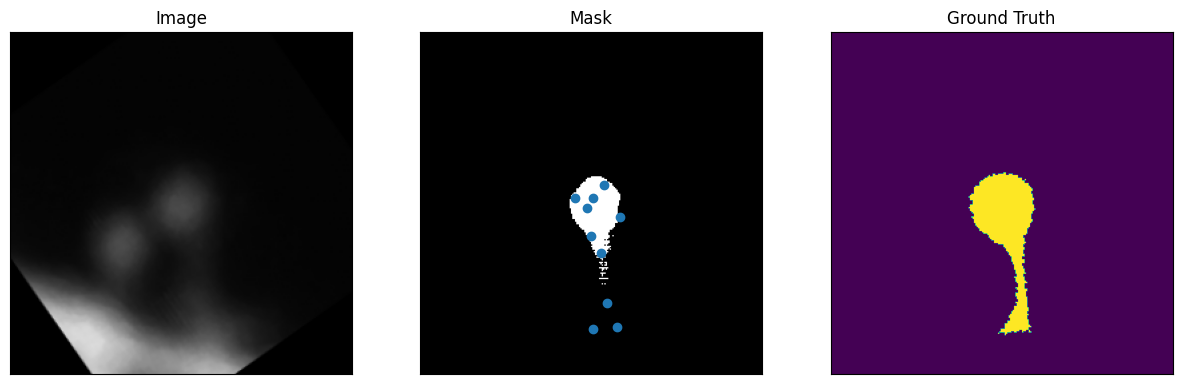

In [45]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(test_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(medsam_seg, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")
axes[1].scatter(points[:,1],points[:,0])

# Plot the second image on the right
axes[2].imshow(gt)  # Assuming the second image is grayscale
axes[2].set_title("Ground Truth")


# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

In [46]:
##no prompts
inputs_noprompt = processor(test_image, return_tensors="pt")
inputs_noprompt = {k: v.to(device) for k, v in inputs_noprompt.items()}

In [47]:
with torch.no_grad():
    outputs = spine_model(**inputs_noprompt, multimask_output=False)
# apply sigmoid
medsam_seg_prob_ = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob_ = medsam_seg_prob_.cpu().numpy().squeeze()
medsam_seg_ = (medsam_seg_prob_ > 0.5).astype(np.uint8)

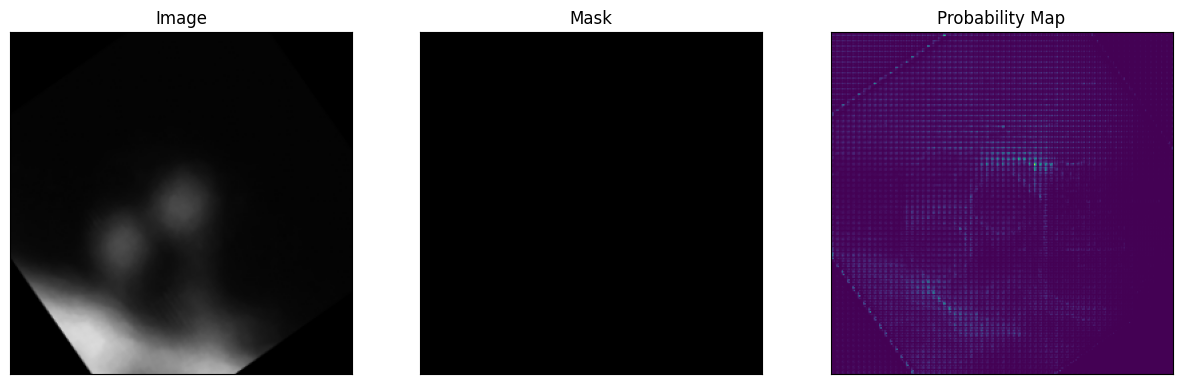

In [48]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(test_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(medsam_seg_, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Plot the second image on the right
axes[2].imshow(medsam_seg_prob_)  # Assuming the second image is grayscale
axes[2].set_title("Probability Map")


# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()